In [166]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [167]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [168]:
NUM_CLASSES = 25

# 学習データ読み込み

In [169]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [170]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [172]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [173]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_16 (Dropout)        (None, 42)                0         
                                                                 
 dense_24 (Dense)            (None, 20)                860       
                                                                 
 dropout_17 (Dropout)        (None, 20)                0         
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
 dense_26 (Dense)            (None, 24)                264       
                                                                 
Total params: 1,334
Trainable params: 1,334
Non-trainable params: 0
_________________________________________________________________


In [174]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [175]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [176]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
74/88 [========================>.....] - ETA: 0s - loss: 3.0904 - accuracy: 0.1111
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
88/88 [==============================] - 1s 5ms/step - loss: 3.0790 - accuracy: 0.1102 - val_loss: 2.9234 - val_accuracy: 0.1585
Epoch 2/1000
72/88 [=======================>......] - ETA: 0s - loss: 2.8451 - accuracy: 0.1361
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
88/88 [==============================] - 0s 4ms/step - loss: 2.8183 - accuracy: 0.1361 - val_loss: 2.5854 - val_accuracy: 0.1443
Epoch 3/1000
75/88 [========================>.....] - ETA: 0s - loss: 2.5946 - accuracy: 0.1675
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
88/88 [==============================] - 0s 3ms/step - loss: 2.5854 - accuracy: 0.1681 - val_loss: 2.3541 - val_accuracy: 0.2326
Epoch 4/1000
74/88 [========================>.....] - ETA: 0s - loss: 2.4310 - accuracy: 0.1963
E

In [177]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

30/30 [==============================] - 0s 1ms/step - loss: 0.5551 - accuracy: 0.8215


In [178]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [179]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 53ms/step
[1.5781511e-02 1.4659255e-02 3.0006817e-02 4.8784557e-07 2.6833813e-04
 6.1713081e-08 4.5366094e-01 4.8318073e-01 1.0771762e-09 1.1023599e-11
 1.6203876e-05 2.8168806e-06 7.0441027e-05 4.5275347e-06 9.6701831e-04
 1.8287594e-13 1.1561264e-09 9.2844502e-04 8.4164363e-05 2.6948497e-04
 1.5820910e-14 1.9819661e-10 1.0486018e-15 9.8763543e-05]
7


# 混同行列

117/117 [==============================] - 0s 1ms/step


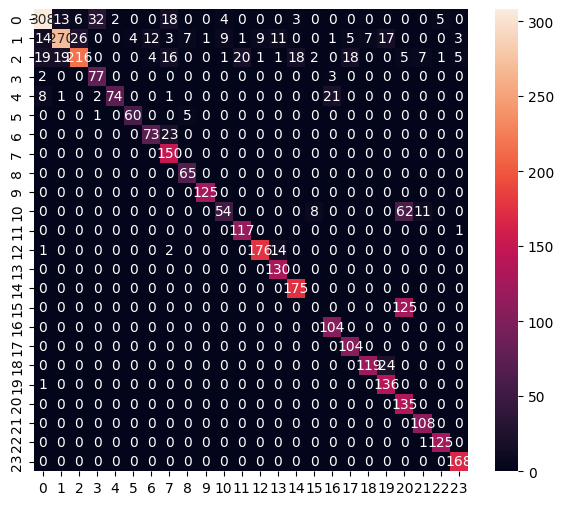

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       391
           1       0.89      0.68      0.77       400
           2       0.87      0.61      0.72       353
           3       0.69      0.94      0.79        82
           4       0.97      0.69      0.81       107
           5       0.94      0.91      0.92        66
           6       0.82      0.76      0.79        96
           7       0.70      1.00      0.83       150
           8       0.84      1.00      0.92        65
           9       0.99      1.00      1.00       125
          10       0.79      0.40      0.53       135
          11       0.85      0.99      0.91       118
          12       0.95      0.91      0.93       193
          13       0.83      1.00      0.91       130
          14       0.89      1.00      0.94       175
          15       0.00      0.00      0.00       125
          16       0.81      1.00      0.89       104
     

In [180]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [181]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [182]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmpbp5ib24y\assets


INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmpbp5ib24y\assets


7488

# 推論テスト

In [183]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [184]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [185]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [186]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [187]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.57815069e-02 1.46592809e-02 3.00068334e-02 4.87846592e-07
 2.68338568e-04 6.17130951e-08 4.53661680e-01 4.83179957e-01
 1.07717846e-09 1.10235605e-11 1.62038796e-05 2.81687880e-06
 7.04412378e-05 4.52755285e-06 9.67016153e-04 1.82874928e-13
 1.15613330e-09 9.28445777e-04 8.41644578e-05 2.69485055e-04
 1.58208526e-14 1.98195529e-10 1.04860413e-15 9.87638414e-05]
7
